## Monte-Carlo Prediction for Blackjack

Here is the implementation of on-policy every-visit Monte-Carlo algorithm to evaluate state value function $v_\pi$ for a given policy $\pi$. The algorithm is implemented using incremental update.


In [0]:
import numpy as np
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import sys
import gym
from gym import logger as gymlogger

matplotlib.style.use('ggplot')
gymlogger.set_level(40) #error only
%matplotlib inline

## Blackjack environment

A state in Blackjask is defined by three things:<br/>
1. Player current sum (1-31)
2. Dealer's one showing card (1-10)
3. Does player holds a usable ace (0 or 1)

In [2]:
env = gym.make("Blackjack-v0")
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


## On-Policy Every-visit Monte Carlo Prediction

In [0]:
def policy1(state):
    """
    A sample policy to be evaluated
    
    - This policy is same as the one used in Sutton and Barto Example 5.1.
    - This allows to check the results against that mentioned in book
    """

    player_sum, dealer_card, usable_ace = state
    if player_sum >= 20:
        return 0
    return 1

def sample_episode(env, policy):
    """
    Sample an episode using given policy
    """

    state = env.reset()
    episode = []
    while True:
        action = policy(state)
        next_state, reward, done, info = env.step(action)
        episode.append((state,action,reward))
        if done:
            break
        state = next_state
    return episode

def MC_predict(env, policy, num_episodes=10000, gamma=1.0):
    """
    Performs MC on-policy evaluation

    Args:
        env: Learning enviroment, e.g. Blackjack
        policy: Policy to be evaluated
        num_episodes: Number of episodes to sample
        gamma: Discount factor
    Returns:
        state_values: dictionary mapping states (tuple) to their values
    """

    state_counts = defaultdict(int)
    state_values = defaultdict(float)

    for episode_num in range(num_episodes):
        if (episode_num+1) % 1000 == 0:
            print("\rFinished {}/{} episodes".format(episode_num+1,num_episodes), end="")
            sys.stdout.flush()
        episode = sample_episode(env, policy)
        current_return = 0
        T = len(episode)
        for t in reversed(range(T)):
            state, action, reward = episode[t]
            current_return = gamma*current_return + reward
            state_counts[state] += 1
            state_values[state] += (current_return - (gamma*state_values[state])) / float(state_counts[state])
    return state_values

## Helper Functions to Plot State Values

In [0]:
# Following function to plot the Blackjack value function is based on the
# implementation here: https://github.com/dennybritz/reinforcement-learning/

def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x, max_x = 11, 22
    min_y, max_y = min(k[1] for k in V.keys()), max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, ax, title):
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)

    fig = plt.figure(figsize=(20, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    plot_surface(X, Y, Z_noace, ax1, "{} (No Usable Ace)".format(title))
    ax2 = fig.add_subplot(122, projection='3d')
    plot_surface(X, Y, Z_ace, ax2, "{} (Usable Ace)".format(title))

## Run Model and Plot Results

Finished 20000/20000 episodes

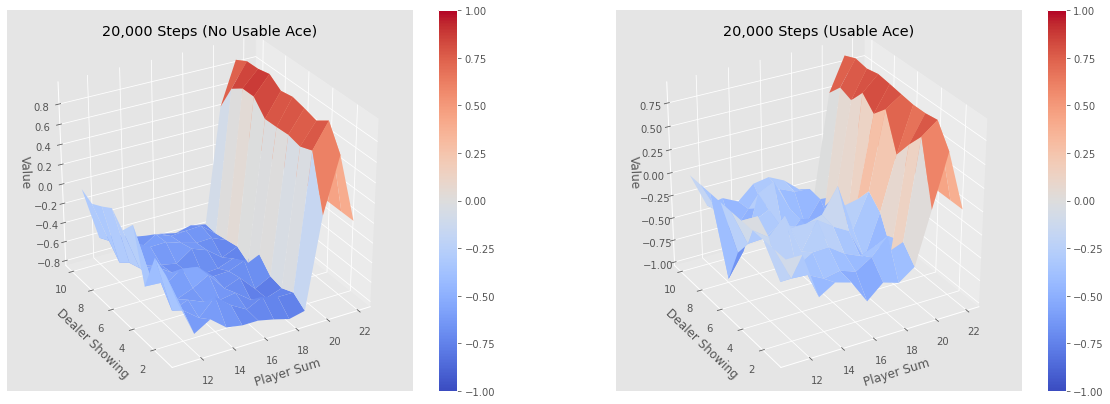

In [5]:
mc_values_20k = MC_predict(env, policy1, num_episodes=20000)
plot_value_function(mc_values_20k, title="20,000 Steps")

Finished 500000/500000 episodes

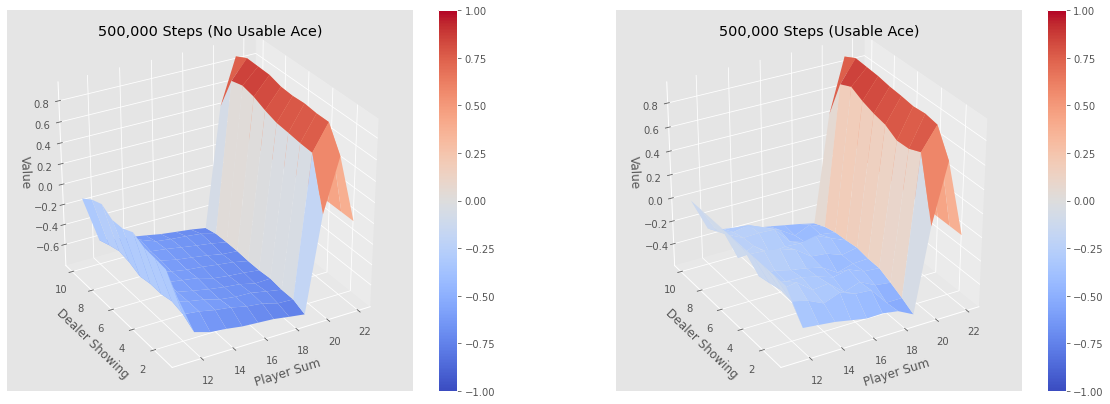

In [6]:
mc_values_500k = MC_predict(env, policy1, num_episodes=500000)
plot_value_function(mc_values_500k, title="500,000 Steps")